In [4]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn
seaborn.set()
from random import shuffle

from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import einops
# import pickle
import os
# import nibabel as nib
# import skimage.transform as skTrans
import numpy as np


In [ ]:
#split train and dev data
names = os.listdir('ct_train')
shuffle(names)

train_names = names[:int(len(names) * 0.8)]
dev_names = names[int(len(names) * 0.8):]
os.mkdir('train_data')
for i in train_names:
    os.rename('ct_train/' + i, 'train_data/' + i)
    os.rename('ct_train_masks/' + i, 'train_data/' + i.split('.')[0] + '_seg.nii.gz')

os.mkdir('dev_data')
for i in dev_names:
    os.rename('ct_train/' + i, 'dev_data/' + i)
    os.rename('ct_train_masks/' + i, 'dev_data/' + i.split('.')[0] + '_seg.nii.gz')



In [ ]:
# processing data to torch_dataset
data = {'train': {}, 'dev': {}, 'test': {}}
for p in ['train', 'dev']:
    dir = p + '_data'
    names = os.listdir(dir)
    def get_resized_data(data_name):
        im = nib.load(data_name)
        result1 = skTrans.resize(im.get_fdata(), (32, 32, 32), order=1, preserve_range=True)
        result1 = (result1 - result1.min()) / (result1.max() - result1.min())
        print(im.get_fdata().shape)
        if 'seg' in data_name:  
            result1 = np.array(result1 > 0.5, dtype=float)
        else:
            pass
        return result1

    for name in tqdm(names):
        A = get_resized_data(os.path.join(dir, name))
        id = name.split('.')[0].replace('_seg', '')
        if 'seg' in name:
            if id in data[p]:
                data[p][id]['label'] = A
            else:
                data[p][id] = {'label': A}
        else:
            if id in data[p]:
                data[p][id]['data'] = A
            else:
                data[p][id] = {'data': A}

            


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
image = []
label = []
for _, d in data['train'].items():
    if 'label' in d.keys() and 'data' in d.keys():
        image.append(d['data'])
        label.append(d['label'])

image = torch.tensor(np.stack(image), dtype=torch.float32)
label = torch.tensor(np.stack(label), dtype=torch.float32)
train_dataset = TensorDataset(image, label)
torch.save(train_dataset, 'train_dataset.pt')

image = []
label = []
for _, d in data['dev'].items():
    if 'label' in d.keys() and 'data' in d.keys():
        image.append(d['data'])
        label.append(d['label'])

image = torch.tensor(np.stack(image), dtype=torch.float32)
label = torch.tensor(np.stack(label), dtype=torch.float32)
dev_dataset = TensorDataset(image, label)
torch.save(dev_dataset, 'dev_dataset.pt')


In [3]:
# torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch_device = 'cuda'
root_folder = r"."

In [32]:
def patchify(images, patch_size=4):
    """Splitting images into patches.
    Args:
        images: Input tensor with size (batch, channels, height, width)
            We can assume that image is square where height == width.
    Returns:
        A batch of image patches with size (
          batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    Hint: use einops.rearrange. The "space-to-depth operation" example at https://einops.rocks/api/rearrange/ 
    is not exactly what you need, but it gives a good idea of how to use rearrange.
    """
    return einops.rearrange(
        images,
        'b (h p1) (w p2) (d p3) -> b (h w d) (p1 p2 p3)',
        p1=patch_size,
        p2=patch_size,
        p3=patch_size
    )

def unpatchify(patches, patch_size=4):
    """Combining patches into images.
    Args:
        patches: Input tensor with size (
        batch, (height / patch_size) * (width / patch_size), 
        channels * patch_size * patch_size)
    Returns:
        A batch of images with size (batch, channels, height, width)
        
    Hint: einops.rearrange can be used here as well.
    """
    return einops.rearrange(
        patches,
        'b (h w d) (p1 p2 p3) -> b (h p1) (w p2) (d p3)',
        p1=patch_size,
        p2=patch_size,
        p3=patch_size,
        h=32 // patch_size,
        w=32 // patch_size,
        d=32 // patch_size
    )



In [6]:

class Transformer(nn.Module):
    """Transformer Encoder 
    Args:
        embedding_dim: dimension of embedding
        n_heads: number of attention heads
        n_layers: number of attention layers
        feedforward_dim: hidden dimension of MLP layer
    Returns:
        Transformer embedding of input
    """
    def __init__(self, embedding_dim=256, n_heads=4, n_layers=4, feedforward_dim=1024):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.feedforward_dim = feedforward_dim
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=self.n_heads,
                dim_feedforward=self.feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.0,
            ),
            num_layers=n_layers,
        )

    def forward(self, x):
        return self.transformer(x)

batch_size = 32

trainset = torch.load('train_dataset.pt')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torch.load('dev_dataset.pt')
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [7]:

def index_sequence(x, ids):
    """Index tensor (x) with indices given by ids
    Args:
        x: input sequence tensor, can be 2D (batch x length) or 3D (batch x length x feature)
        ids: 2D indices (batch x length) for re-indexing the sequence tensor
    """
    if len(x.shape) == 3:
        ids = ids.unsqueeze(-1).expand(-1, -1, x.shape[-1])
    return torch.take_along_dim(x, ids, dim=1)

def random_masking(x, keep_length, ids_shuffle):
    """Apply random masking on input tensor
    Args:
        x: input patches (batch x length x feature)
        keep_length: length of unmasked patches
        ids_shuffle: random indices for shuffling the input sequence. This is an
            array of size (batch x length) where each row is a permutation of 
            [0, 1, ..., length-1]. We will pass this array to index_sequence function
            to chooose the unmasked patches.
    Returns:
        kept: unmasked part of x
        mask: a 2D (batch x length) mask tensor of 0s and 1s indicated which
            part of x is masked out. The value 0 indicates not masked and 1
            indicates masked.
        ids_restore: indices to restore x. This is an array of size (batch x length).
            If we take the kept part and masked
            part of x, concatentate them together and index it with ids_restore,
            we should get x back. (Hint: try using torch.argsort on the shuffle indices)

    Hint:
        ids_shuffle contains the indices used to shuffle the sequence (patches).
        You should use the provided index_sequence function to re-index the
        sequence, and keep the first keep_length number of patches.
    """
    # BEGIN YOUR CODE
    ids_broadcast = ids_shuffle[:, :, None].repeat(1, 1, x.shape[2])
    x_shuffled = torch.gather(x, 1, ids_broadcast)
    kept = x_shuffled[:, :keep_length]
    ids_restore = torch.argsort(ids_shuffle)
    mask = torch.zeros_like(ids_shuffle)
    mask[:, :keep_length] = 1
    mask = 1 - torch.gather(mask, 1, ids_restore)

    return kept, mask, ids_restore


    # END YOUR CODE

def restore_masked(kept_x, masked_x, ids_restore):
    """Restore masked patches
    Args:
        kept_x: unmasked patches: (batch x keep_length x feature)
        masked_x: masked patches: (batch x (length - keep_length) x feature)
        ids_restore: indices to restore x: (batch x length)
    Returns:
        restored patches
    Hint: call the index_sequence function on an array with the kept and masked tokens concatenated
    """
    # BEGIN YOUR CODE
    all_x = torch.concat([kept_x, masked_x], dim=1)
    restored_x = torch.gather(all_x, 1, ids_restore[:, :, None].repeat(1, 1, all_x.shape[2]))
    return restored_x

    # END YOUR CODE

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MAE Train Loss')

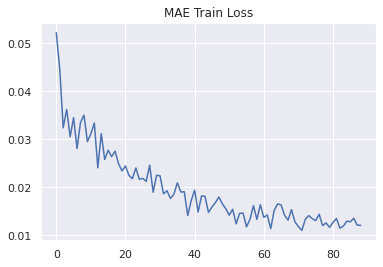

In [42]:

class MaskedAutoEncoder(nn.Module):
    """MAE Encoder
    Args:
        encoder: vit encoder
        decoder: vit decoder
        encoder_embedding_dim: embedding size of encoder
        decoder_embedding_dim: embedding size of decoder
        patch_size: image patch size
        num_patches: number of patches
        mask_ratio: percentage of masked patches
    """
    def __init__(self, encoder, decoder, encoder_embedding_dim=256, 
                 decoder_embedding_dim=128, patch_size=4, num_patches=8,
                 mask_ratio=0.75):
        super().__init__()
        self.encoder_embedding_dim = encoder_embedding_dim
        self.decoder_embedding_dim = decoder_embedding_dim
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio

        self.masked_length = int(num_patches * mask_ratio)
        self.keep_length = num_patches - self.masked_length

        self.encoder = encoder
        self.decoder = decoder

        self.encoder_input_projection = nn.Linear(patch_size * patch_size * patch_size, encoder_embedding_dim)
        self.decoder_input_projection = nn.Linear(encoder_embedding_dim, decoder_embedding_dim)
        self.decoder_output_projection = nn.Linear(decoder_embedding_dim, patch_size * patch_size * patch_size)
        self.cls_token = nn.Parameter(torch.randn(1, 1, encoder_embedding_dim) * 0.02)
        self.encoder_position_encoding = nn.Parameter(torch.randn(1, num_patches, encoder_embedding_dim) * 0.02)
        self.decoder_position_encoding = nn.Parameter(torch.randn(1, num_patches, decoder_embedding_dim) * 0.02)
        self.masked_tokens = nn.Parameter(torch.randn(1, 1, decoder_embedding_dim) * 0.02)

    def forward_encoder(self, images, ids_shuffle=None):
        """Encode input images
        You should implement the following steps
        (1) patchify images into patches
        (2) linear projection
        (3) add position encoding
        (4) mask out some of the patches
        (5) concatenate cls_token and patches embedding and pass it to vit encoder
        """
        batch_size = images.shape[0]
        # Generate random shuffling indices
        if ids_shuffle is None:
            ids_shuffle = torch.argsort(
                torch.rand(
                    (batch_size, self.num_patches),
                    device=images.device
                ),
                dim=1
            )
        # BEGIN YOUR CODE
        patched_images = patchify(images, patch_size=self.patch_size)
        embedded_images = self.encoder_input_projection(patched_images)
        embedded_images += self.encoder_position_encoding
        kept, mask, ids_restore = random_masking(embedded_images, self.keep_length, ids_shuffle)
        encoder_input = torch.concat([self.cls_token.repeat(batch_size, 1, 1), kept], dim=1)
        encoder_output = self.encoder(encoder_input)
        return encoder_output, mask, ids_restore

        # END YOUR CODE

    def forward_decoder(self, encoder_embeddings, ids_restore):
        """Decode encoder embeddings
        You should implement the following steps
        (1) linear projection of encoder embeddings
        (2) restore sequence from masked_patches and encoder predictions
            We need our decoder output to have the same number of tokens as the original patched input, 
            but our encoder currently is missing some tokens that we masked out. We need to add some dummy 
            tokens back to our embedded tokens so when our decoder outputs, it has the correct number of 
            tokens that can be interpreted as sequential patches of output image.
            During this step, you should remove the CLS token from the sequence.
        (3) add position encoding
        (3) re-concatenate/use CLS token and decode using ViT decoder 
        (4) projection to predict image patches
        """
        # BEGIN YOUR CODE
        batch_size, sequence_length = ids_restore.shape
        decoder_projected = self.decoder_input_projection(encoder_embeddings)
        cls_token = decoder_projected[:, 0:1]
        projected = decoder_projected[:, 1:]
        dummy_tokens = self.masked_tokens.repeat(batch_size, sequence_length - self.keep_length, 1)
        restored = restore_masked(projected, dummy_tokens, ids_restore)
        decoder_input = restored + self.decoder_position_encoding
        decoder_input = torch.concat([cls_token, decoder_input], dim=1)
        decoder_output = self.decoder(decoder_input)[:, 1:]
        decoder_output = self.decoder_output_projection(decoder_output)
        return decoder_output
        
        # END YOUR CODE

    def forward(self, images):
        encoder_output, mask, ids_restore = self.forward_encoder(images)
        decoder_output = self.forward_decoder(encoder_output, ids_restore)
        return decoder_output, mask

    def forward_encoder_representation(self, images):
        """Encode images without applying random masking to get representation
        of input images. 

        You should implement splitting images into patches, re-concatenate/use CLS token,
        and encoding with ViT encoder.
        """
        # BEGIN YOUR CODE
        batch_size = images.shape[0]
        patched_images = patchify(images, patch_size=self.patch_size)
        embedded_images = self.encoder_input_projection(patched_images)
        embedded_images += self.encoder_position_encoding
        encoder_input = torch.concat([self.cls_token.repeat(batch_size, 1, 1), embedded_images], dim=1)
        encoder_output = self.encoder(encoder_input)
        return encoder_output
        # END YOUR CODE

# Initilize MAE model
model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=6),
    Transformer(embedding_dim=128, n_layers=6),
    patch_size=8,
    num_patches=64
)
# Move the model to GPU
model.to(torch_device)
# Create optimizer

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=0.05)

total_steps = 0
num_epochs = 50
train_logfreq = 100

losses = []

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x = x.to(torch_device)
        image_patches = patchify(x, patch_size=model.patch_size)
        predicted_patches, mask = model(x)
        loss = torch.sum(torch.mean(torch.square(image_patches - predicted_patches), dim=-1) * mask) / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())
        if total_steps % train_logfreq == 0:
            losses.append(loss.item())

    # Periodically save model
    torch.save(model.state_dict(), os.path.join(root_folder, "mae_pretrained.pt"))

plt.plot(losses)
plt.title('MAE Train Loss')


In [43]:
class SegmentationMAE(nn.Module):
    """A linear classifier is trained on self-supervised representations learned by MAE. 
    Args:
        n_classes: number of classes
        mae: mae model
        embedding_dim: embedding dimension of mae output
        detach: if True, only the classification head is updated.
    """
    def __init__(self, mae, embedding_dim=256, detach=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.mae = mae
        self.mae.mask_ratio = 0
        """
        When self.detach=True, use linear classification, when self.detach=False,
        use full finetuning.
        """
        self.detach = detach

    def forward(self, images):
        """
        Args:
            Images: batch of images
        Returns:
            logits: batch of logits from the ouput_head
        Remember to detach the representations if self.detach=True, and 
        Remember that we do not use masking here.
        """
        # BEGIN YOUR CODE
        mae_output = self.mae(images)[0]
        output = unpatchify(mae_output, 8)
        return output
        # END YOUR CODE




  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Linear Classification Val Accuracy')

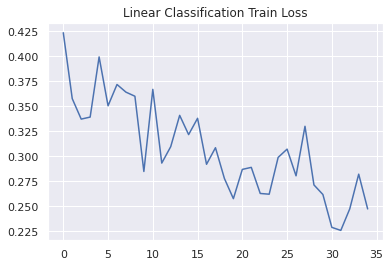

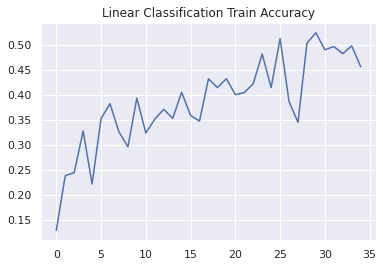

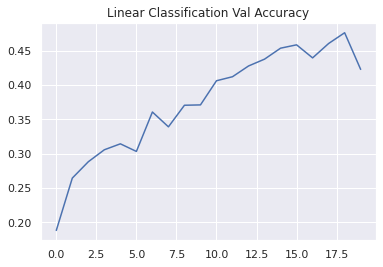

In [41]:
#@title Test your implementation
mae = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=6),
    Transformer(embedding_dim=128, n_layers=6),
    patch_size=8,
    num_patches=64
)
mae.load_state_dict(torch.load(os.path.join(root_folder, "mae_pretrained.pt")))

# Initilize classification model; set detach=True to only update the linear classifier. 
model = SegmentationMAE(mae, detach=True)
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 50
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device).float()
        logits = model(x)
        loss = torch.mean(F.binary_cross_entropy_with_logits(logits, y))
        accuracy = ((logits > 0) & (y == 1)).count_nonzero() / ((logits > 0) | (y == 1)).count_nonzero()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device).float()
        with torch.no_grad():
          logits = model(x)
        accuracy = ((logits > 0) & (y == 1)).count_nonzero() / ((logits > 0) | (y == 1)).count_nonzero()
        val_acc.append(accuracy.item())

    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Linear Classification Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Linear Classification Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Linear Classification Val Accuracy')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

  0%|          | 0/179 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Linear Classification Val Accuracy')

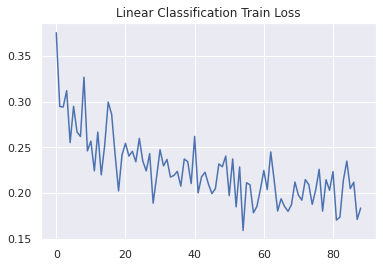

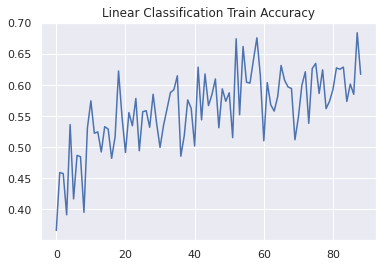

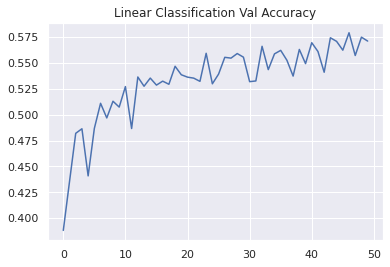

In [44]:
#@title Test your implementation
mae = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=6),
    Transformer(embedding_dim=128, n_layers=6),
    patch_size=8,
    num_patches=64
)
mae.load_state_dict(torch.load(os.path.join(root_folder, "mae_pretrained.pt")))

# Initilize classification model; set detach=True to only update the linear classifier. 
model = SegmentationMAE(mae, detach=True)
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 50
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device).float()
        logits = model(x)
        loss = torch.mean(F.binary_cross_entropy_with_logits(logits, y))
        accuracy = ((logits > 0) & (y == 1)).count_nonzero() / ((logits > 0) | (y == 1)).count_nonzero()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device).float()
        with torch.no_grad():
          logits = model(x)
        accuracy = ((logits > 0) & (y == 1)).count_nonzero() / ((logits > 0) | (y == 1)).count_nonzero()
        val_acc.append(accuracy.item())

    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

plt.plot(losses)
plt.title('Linear Classification Train Loss')
plt.figure()
plt.plot(train_acc)
plt.title('Linear Classification Train Accuracy')
plt.figure()
plt.plot(all_val_acc)
plt.title('Linear Classification Val Accuracy')